# Visium DLPFC

In this notebook we demonstrate how mosna can be used to analyze spatiallly resolved omics data.  
The data used is from the publication by [Maynard et al.](https://www.nature.com/articles/s41593-020-00787-0) "Transcriptome-scale spatial gene expression in the human dorsolateral prefrontal cortex".  
Here 12 samples were processed with the [Visium](https://www.science.org/doi/10.1126/science.aaf2403) platform to produce maps of transcripts per spots.  

## Imports and data loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from time import time
import warnings
import joblib
from pathlib import Path
from time import time
from tqdm import tqdm
import copy
import matplotlib as mpl
import napari
import colorcet as cc
import composition_stats as cs
from sklearn.impute import KNNImputer
from lifelines import KaplanMeierFitter, CoxPHFitter

import anndata as ad
import scanpy as sc
import scvi

from tysserand import tysserand as ty
from mosna import mosna

import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = 'white'
mpl.rcParams["axes.facecolor"] = 'white'
mpl.rcParams["savefig.facecolor"] = 'white'

Global seed set to 0


In [2]:
# If need to reload modules after their modification
from importlib import reload
ty = reload(ty)
mosna = reload(mosna)

### Objects data

Load files that contains all the detected objects (the cells) across all samples and clinical data.  
Data is available here: https://github.com/LieberInstitute/HumanPilot/tree/master and at [Globus](http://research.libd.org/globus/) (`jhpce#HumanPilot10x`).

In [3]:
data_dir = Path("../../HumanPilot/10X/")
sample_ids = [
    '151507', 
    '151508', 
    '151509', 
    '151510', 
    '151669', 
    '151670', 
    '151671', 
    '151672', 
    '151673', 
    '151674', 
    '151675', 
    '151676'
]

In [4]:
annotations = pd.read_csv(data_dir / 'barcode_level_layer_map.tsv', sep='\t', header=None)
annotations.columns = ['barcodes', 'sample_id', 'layer']
# make unique barcodes with sample_id
annotations['barcodes'] = annotations['barcodes'] + '-' + annotations['sample_id'].astype(str)
annotations

,barcodes,sample_id,layer
0,AAACAACGAATAGTTC-1-151507,151507,L1
1,AAACAAGTATCTCCCA-1-151507,151507,L3
2,AAACAATCTACTAGCA-1-151507,151507,L1
3,AAACACCAATAACTGC-1-151507,151507,WM
4,AAACAGCTTTCAGAAG-1-151507,151507,L6
...,...,...,...
47324,TTGTTGTGTGTCAAGA-1-151676,151676,L6
47325,TTGTTTCACATCCAGG-1-151676,151676,WM
47326,TTGTTTCATTAGTCTA-1-151676,151676,WM
47327,TTGTTTCCATACAACT-1-151676,151676,L6


In [5]:
annotations['sample_id'].value_counts()

sample_id
151509    4788
151510    4595
151508    4381
151507    4221
151671    4093
151672    3888
151669    3636
151674    3635
151673    3611
151675    3566
151670    3484
151676    3431
Name: count, dtype: int64

In [ ]:
# # rename files to use `sc.read_visium`
# for sample_id in sample_ids:
#     path_dir = data_dir / f'{sample_id}'
#     path_dir_spatial = path_dir / 'spatial'
#     path_dir_spatial.mkdir(parents=True, exist_ok=True)

#     for path, directories, files in os.walk(path_dir):
#         for file in files:
#             if file.startswith(sample_id):
#                 new_name = file.replace(f'{sample_id}_', '')
#                 os.rename(os.path.join(path, file), os.path.join(path, new_name))
#             if file == 'tissue_positions_list.txt':
#                 os.rename(os.path.join(path, file), os.path.join(path_dir_spatial, 'tissue_positions_list.csv'))
#             elif file.endswith('res_image.png'):
#                 os.rename(os.path.join(path, file), os.path.join(path_dir_spatial, file))
#             elif file == 'scalefactors_json.json':
#                 os.rename(os.path.join(path, file), os.path.join(path_dir_spatial, file))

### Explore single sample

In [ ]:
hvgs=5000

sample_id = sample_ids[0]
sample_dir = data_dir / f'{sample_id}'
adata = sc.read_visium(path=sample_dir)
adata.var_names_make_unique()

sc.pp.filter_genes(adata, min_counts=3)
sc.pp.filter_cells(adata, min_counts=3)

adata.layers["counts"] = adata.X.copy()
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=hvgs,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# make unique barcodes with sample_id
adata.obs.index = adata.obs.index + '-' + str(sample_id)

In [ ]:
adata

In [ ]:
layer_guess = annotations.loc[annotations['sample_id'] == int(sample_id)]
layer_guess.index = layer_guess['barcodes']
layer_guess.index.name = None
layer_guess = layer_guess.drop(columns=['barcodes', 'sample_id'])

adata.obs['layer_guess'] = layer_guess
adata.obs.loc[adata.obs['layer_guess'].isna(), 'layer_guess'] = 'none'

In [ ]:
adata.obs

In [ ]:
adata.obs['layer_guess'].value_counts()

In [ ]:
# make common color mapper
cycle_cmap = False

nodes_labels = adata.obs['layer_guess']
uniq = pd.Series(nodes_labels).value_counts().index

if nodes_labels is not None:
    nb_clust = len(uniq)
    uniq = pd.Series(nodes_labels).value_counts().index

    # choose colormap
    clusters_cmap = mosna.make_cluster_cmap(uniq)
    # make color mapper
    # series to sort by decreasing order
    n_colors = len(clusters_cmap)
    nodeclusters_color_mapper = {x: clusters_cmap[i % n_colors] for i, x in enumerate(uniq)}

In [ ]:
nodeclusters_color_mapper

In [ ]:
adata.uns['spatial'][sample_id]['images']['hires'].shape

In [ ]:
plt.imshow(adata.uns['spatial'][sample_id]['images']['hires']);

In [ ]:
plt.scatter(adata.obsm['spatial'][:, 0], adata.obsm['spatial'][:, 1], s=1, marker='.');

In [ ]:
coords = adata.obsm['spatial']
pairs = ty.build_lattice(coords)

In [ ]:
fig, ax = ty.plot_network(
    coords, pairs, labels=nodes_labels,
    color_mapper=nodeclusters_color_mapper, 
    legend_opt={'loc': 'center left', 'bbox_to_anchor': (1.05, 0.5)},
    )
plt.title("sample {}".format(sample_id));

In [ ]:
adata

In [ ]:
adata.layers['counts']

In [ ]:
n_zeros = np.sum(adata.layers['counts'] == 0)
n_finite = adata.layers['counts'].size
m, n = adata.layers['counts'].shape
print(m * n == n_finite + n_zeros)
print(n_zeros / (m *n))

## Cellular neighborhoods

In [ ]:
order = 1
var_type = 'genexp'
stat_names = 'mean-std'
# aggreg_vars = pheno_cols

# For UMAP visualization
marker = '.'
size_points = 10

nas_dir = reconst_dir / f"nas_on-{var_type}_stats-{stat_names}_order-{order}"    
nas_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
order = 1
stat_funcs='default'
stat_names='default'
# stat_funcs = np.mean
# stat_names = 'mean'
var_names = adata.var.loc[adata.var['highly_variable']].index
    
nas = mosna.make_features_NAS(
    adata.layers['counts'].toarray(), 
    pairs, 
    order=order, 
    var_names=var_names, 
    stat_funcs=stat_funcs, 
    stat_names=stat_names, 
    )

In [ ]:
nas

### Pre-process all samples

In [6]:
cluster_ids = {
    '151507': 7, 
    '151508': 7, 
    '151509': 7, 
    '151510': 7, 
    '151669': 5, 
    '151670': 5, 
    '151671': 5, 
    '151672': 5, 
    '151673': 7, 
    '151674': 7, 
    '151675': 7, 
    '151676': 7,
    }

patient_ids = {
    '151507': 0, 
    '151508': 0, 
    '151509': 0, 
    '151510': 0, 
    '151669': 1, 
    '151670': 1, 
    '151671': 1, 
    '151672': 1, 
    '151673': 2, 
    '151674': 2, 
    '151675': 2, 
    '151676': 2,
    }

In [ ]:
# cohort aggregation
hvgs = 5000
remove_none_spots = True

adatas = []
for sample_id, n_clusters in cluster_ids.items():
    sample_dir = data_dir / f'{sample_id}'
    adata = sc.read_visium(path=sample_dir)
    adata.var_names_make_unique()
    # adata.obs_names_make_unique()
    adata.obs['sample'] = [sample_id] * adata.shape[0]
    adata.obs['patient'] = [patient_ids[sample_id]] * adata.shape[0]

    # make unique barcodes with sample_id
    adata.obs.index = adata.obs.index + '-' + str(sample_id)
    
    adatas.append(adata)

adata = ad.concat(adatas, pairwise=True)
# adata.var_names_make_unique()

sc.pp.filter_genes(adata, min_counts=3)
sc.pp.filter_cells(adata, min_counts=3)

adata.layers["counts"] = adata.X.copy()

sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(
    adata,
    n_top_genes=hvgs,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
)

# add manual annotations
layer_guess = annotations.copy()
layer_guess.index = layer_guess['barcodes']
layer_guess.index.name = None
layer_guess = layer_guess.drop(columns=['barcodes', 'sample_id'])
adata.obs['layer_guess'] = layer_guess
if remove_none_spots:
    adata = adata[~adata.obs['layer_guess'].isna()]
else:
    adata.obs.loc[adata.obs['layer_guess'].isna(), 'layer_guess'] = 'none'

# make common color mapper
nodes_labels = adata.obs['layer_guess']
uniq = pd.Series(nodes_labels).value_counts().index

if nodes_labels is not None:
    nb_clust = len(uniq)
    uniq = pd.Series(nodes_labels).value_counts().index

    # choose colormap
    clusters_cmap = mosna.make_cluster_cmap(uniq)
    # make color mapper
    # series to sort by decreasing order
    n_colors = len(clusters_cmap)
    nodeclusters_color_mapper = {x: clusters_cmap[i % n_colors] for i, x in enumerate(uniq)}

In [ ]:
# adata.obs_names_make_unique() # manually done

In [ ]:
# batch correction
n_latent = 5
seed = 0
scvi.settings.seed = seed

scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="patient")
model = scvi.model.SCVI(adata, n_latent=n_latent)
model.train(early_stopping=True)
adata.obsm['X_scVI'] = model.get_latent_representation(adata).astype(np.float32)

In [ ]:
adata.write(data_dir / f"batch_corrected_hvgs{hvgs}_nlatent{n_latent}_joint.h5ad")

Use scanorama to perform batch correction

In [ ]:
import scanpy.external as sce

In [ ]:
sc.tl.pca(adata)
sce.pp.scanorama_integrate(adata, 'patient')

In [ ]:
adata.obsm['X_scanorama'].shape

#### Scanorama batch correction of counts

Scanpy makes it mandatory to run scanorama on PCA components, but we want batch-corrected gene expression, so we'll directly use scanorama.

In [20]:
# check batch effect first
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
adata.obs['patient'] = adata.obs['patient'].astype('category')

/home/alexis/miniconda3/envs/mosna-dl/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca


/home/alexis/miniconda3/envs/mosna-dl/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/alexis/miniconda3/envs/mosna-dl/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


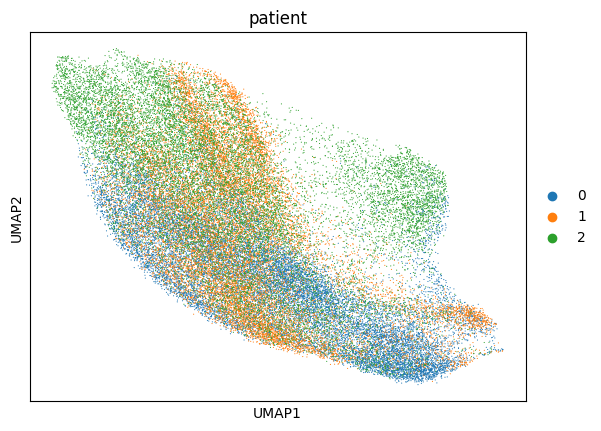

In [21]:
sc.pl.umap(
    adata, 
    color=['patient'],
)

In [22]:
import scanorama

# # Integration.
# scanorama.integrate_scanpy(adatas)

# Batch correction.
# make list of AnnData object per batch key
batch_key = 'patient'
uniq_keys = adata.obs[batch_key].unique()
adatas = [adata[adata.obs[batch_key] == key] for key in uniq_keys]

corrected = scanorama.correct_scanpy(adatas)

Found 5000 genes among all datasets
[[0.         0.61671412 0.2800674 ]
 [0.         0.         0.60386729]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


In [23]:
adata = ad.concat(corrected, pairwise=True)
# adata.obs_names_make_unique()
adata.write(data_dir / f"batch_corrected_scanorama.h5ad")

In [24]:
adata = sc.read_h5ad(data_dir / f"batch_corrected_scanorama.h5ad")

# make common color mapper
nodes_labels = adata.obs['layer_guess']
uniq = pd.Series(nodes_labels).value_counts().index

nb_clust = len(uniq)
uniq = pd.Series(nodes_labels).value_counts().index

# choose colormap
clusters_cmap = mosna.make_cluster_cmap(uniq)
# make color mapper
# series to sort by decreasing order
n_colors = len(clusters_cmap)
nodeclusters_color_mapper = {x: clusters_cmap[i % n_colors] for i, x in enumerate(uniq)}

In [25]:
adata

AnnData object with n_obs × n_vars = 47329 × 5000
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'patient', 'n_counts', 'layer_guess'
    obsm: 'X_pca', 'X_umap', 'spatial'

/home/alexis/miniconda3/envs/mosna-dl/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/alexis/miniconda3/envs/mosna-dl/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


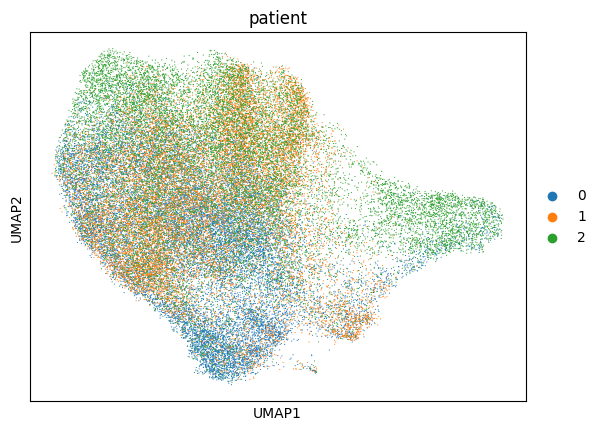

In [26]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

sc.pl.umap(
    adata, 
    color=['patient'],
)

### All samples network reconstruction

In [30]:
# chose optional **additional** data transformation, knowing that
# the 'preprocessed' is already normalized and log1p
use_data = 'preprocessed'
# use_data = 'log1p'

processed_dir = Path('../data/processed/Visium_DLPFC')
reconst_dir = processed_dir / f"samples_networks_hexagonal_lattice_data-{use_data}"
dir_fig_save = processed_dir / 'figures'
reconst_dir.mkdir(parents=True, exist_ok=True)
dir_fig_save.mkdir(parents=True, exist_ok=True)

uniq_patients = adata.obs['patient'].unique()
uniq_samples = adata.obs['sample'].unique()

In [31]:
make_figures = True

for sample_id in uniq_samples:
    print(f"processing sample {sample_id}")
    adaview = adata[adata.obs['sample'] == sample_id]
    patient_id = adaview.obs['patient'].iloc[0]

    coords = adaview.obsm['spatial']
    pairs = ty.build_lattice(coords)
    # add annotations
    nodes_labels = adaview.obs['layer_guess']

    if make_figures:
        fig, ax = ty.plot_network(
            coords, pairs, labels=nodes_labels,
            color_mapper=nodeclusters_color_mapper, 
            legend_opt={'loc': 'center left', 'bbox_to_anchor': (1.05, 0.5)},
            )
        title = f"patient-{patient_id}_sample-{sample_id}"
        plt.title(title);
        plt.axis('off');
        plt.savefig(str(dir_fig_save / title) + '.png', bbox_inches='tight', facecolor='white')
        # plt.show()
        plt.close(fig)


    edges = pd.DataFrame(data=pairs, columns=['source', 'target'])
    edges.to_parquet(reconst_dir / f'edges_patient-{patient_id}_sample-{sample_id}.parquet', index=False)

    if use_data == 'preprocessed':
        data = adaview.X.toarray()
    elif use_data == 'log1p':
        data = np.log(adaview.X.toarray() + 1)
    nodes = pd.DataFrame(
        data=adaview.X.toarray(),
        columns=adaview.var_names,
        index=adaview.obs_names,
    )
    nodes.to_parquet(reconst_dir / f'nodes_patient-{patient_id}_sample-{sample_id}.parquet', index=False)

del data, nodes, edges, coords, pairs

processing sample 151510
processing sample 151669
processing sample 151670
processing sample 151671
processing sample 151672
processing sample 151673
processing sample 151674
processing sample 151675
processing sample 151676


## Cellular neighborhoods

In [32]:
order = 1
var_type = 'counts'
stat_names = 'mean-std'
# stat_funcs='default'
# stat_names='default'
# stat_funcs = np.mean
# stat_names = 'mean'
# aggreg_vars = pheno_cols

# For UMAP visualization
marker = '.'
size_points = 10

nas_dir = reconst_dir / f"nas_on-{var_type}_stats-{stat_names}_order-{order}"    
nas_dir.mkdir(parents=True, exist_ok=True)

In [33]:
reload(ty)
reload(mosna)

<module 'mosna.mosna' from '/home/alexis/Pro/Postdoc_CRCT/Projects/mosna_benchmark/mosna/mosna.py'>

In [34]:
filename = nas_dir / f'aggregation_statistics.parquet'

if filename.exists():
    print('Load aggregation statistics')
    var_aggreg = pd.read_parquet(filename)
else:
    var_aggreg = mosna.compute_NAS_all_networks(
        net_dir=reconst_dir, 
        attributes_col=None, # use all variables
        use_attributes=None, # use all variables 
        make_onehot=False, 
        id_level_1='patient',
        id_level_2='sample', 
        extension='parquet',
        data_index=None,
        parallel_groups=False, #'max', 
        memory_limit='max',
        save_intermediate_results=False, 
        dir_save_interm=None,
        verbose=1,
        )
    var_aggreg.to_parquet(filename, index=False)

data: 100%|██████████| 12/12 [00:22<00:00,  1.92s/it]


In [35]:
var_aggreg

,AASDHPPT mean,AATK mean,ABCA2 mean,ABCA8 mean,ABCB1 mean,ABCC12 mean,ABCC8 mean,ABCC9 mean,ABCG5 mean,ABHD17B mean,...,ZNHIT6 std,ZRSR2 std,ZSCAN29 std,ZSWIM4 std,ZSWIM6 std,ZWILCH std,ZXDA std,ZYG11B std,patient,sample
0,0.012100,0.009073,0.009603,-0.000022,-0.000173,-0.000646,-0.000055,0.000088,0.000071,-0.000369,...,0.000096,0.000025,0.013529,0.000021,0.000138,0.001127,0.000035,0.018968,1,151672
1,0.021565,0.023128,0.019606,0.003946,-0.000185,0.004252,-0.000248,0.000101,0.000071,0.008545,...,0.000316,0.009599,0.000144,0.012000,0.011909,0.000178,0.000029,0.016901,1,151672
2,0.011487,0.026115,0.015070,-0.000023,-0.000126,-0.000598,0.004613,0.000065,0.000074,-0.000242,...,0.001223,0.000074,0.016279,0.000028,0.012854,0.000107,0.000012,0.015039,1,151672
3,0.009919,0.014832,0.009976,-0.000029,-0.000131,-0.000096,-0.000095,0.000657,0.000071,0.005147,...,0.018770,0.008604,0.000649,0.001124,0.015866,0.000749,0.000022,0.015889,1,151672
4,0.026537,0.014871,0.026952,0.004205,-0.000169,0.004180,0.003867,0.000095,0.000069,0.004011,...,0.012747,0.010336,0.000084,0.000031,0.000054,0.000134,0.000014,0.019099,1,151672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3630,0.004819,0.013827,0.037292,0.005080,-0.000120,-0.001050,-0.001365,0.000255,0.000061,0.008345,...,0.015626,0.012332,0.014964,0.000053,0.016944,0.000774,0.000033,0.000779,2,151674
3631,0.000800,0.032259,0.035936,0.001098,0.005237,-0.000971,0.003068,0.000236,0.000054,0.005300,...,0.015715,0.007604,0.000119,0.000069,0.013657,0.000786,0.000014,0.016356,2,151674
3632,0.008141,0.019394,0.008860,0.005537,0.002828,-0.000328,0.004999,0.000181,0.000083,0.004326,...,0.002665,0.000167,0.000224,0.000049,0.004791,0.014371,0.000741,0.010471,2,151674
3633,0.011488,0.006215,0.012499,0.000153,-0.000065,-0.000630,-0.000272,0.000108,0.000062,0.002266,...,0.001028,0.000367,0.000362,0.000034,0.001865,0.000032,0.000017,0.002857,2,151674


In [36]:
# retrieve network info and remove it from NAS table
var_aggreg_samples_info = var_aggreg[['patient', 'sample']]
var_aggreg.drop(columns=['patient', 'sample'], inplace=True)

In [172]:
cluster_params = {
    'reducer_type': 'umap', 
    'n_neighbors': 15, 
    'metric': 'manhattan', # or 'euclidean',
    'min_dist': 0.0,
    'clusterer_type': 'leiden', 
    'dim_clust': 2, 
    'k_cluster': 15, 
    'resolution_parameter': 0.05,
}

cluster_labels, cluster_dir, nb_clust, _ = mosna.get_clusterer(var_aggreg, nas_dir, **cluster_params)

Loading clusterer object and cluster labels
There are 9 clusters


Loading reducer object and reduced coordinates


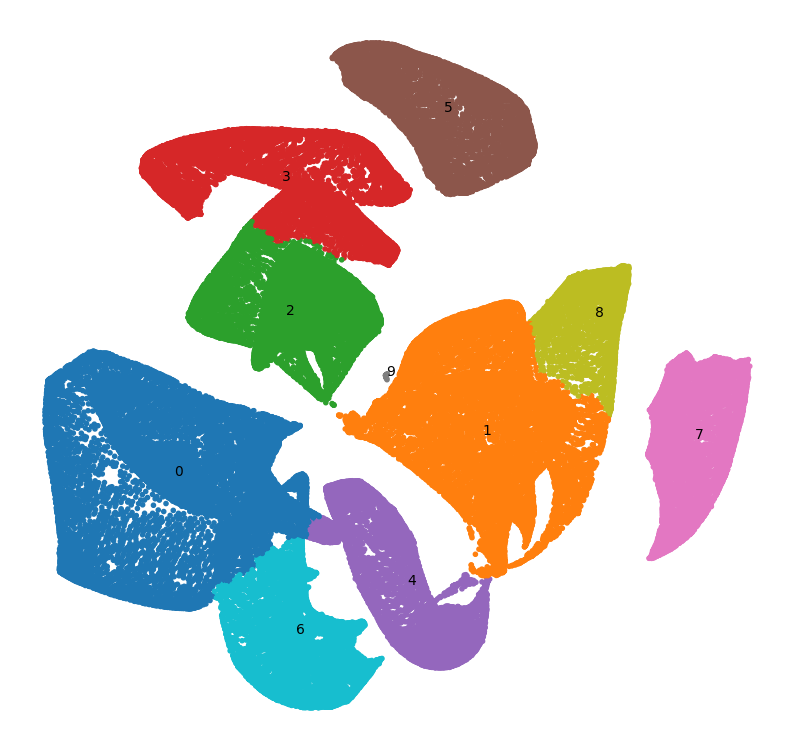

In [173]:
embed_viz, _ = mosna.get_reducer(
    var_aggreg, 
    nas_dir, 
    reducer_type='umap', 
    n_neighbors=15, 
    metric='manhattan',
    )

fig, ax = mosna.plot_clusters(embed_viz, cluster_labels, nas_dir, cluster_params=cluster_params)

Loading clusterer object and cluster labels
There are 9 clusters
cluster 9 merged with cluster 1
cluster 8 merged with cluster 1
cluster 7 merged with cluster 1
maximum number of clusters 7 reached


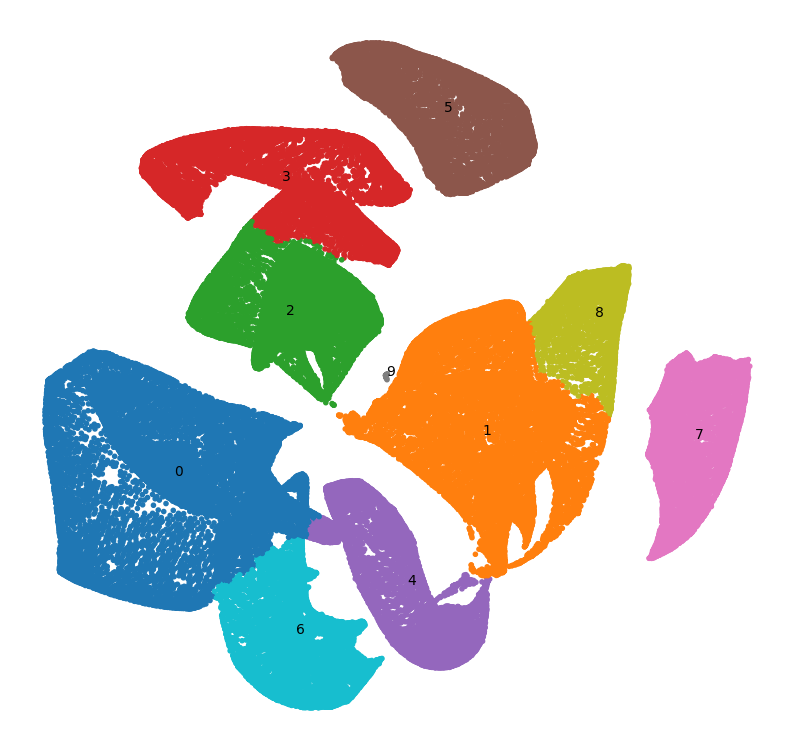

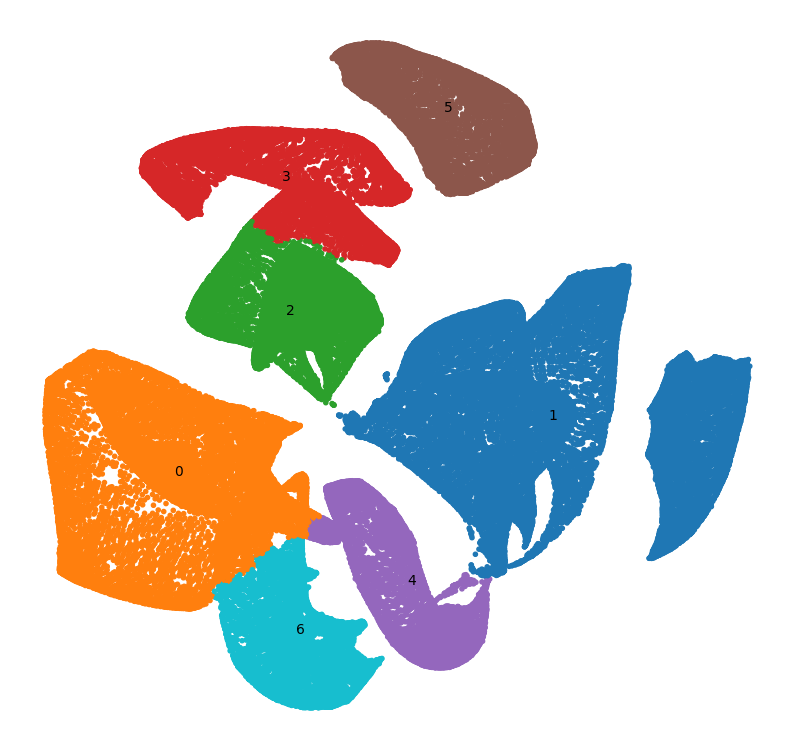

In [176]:
cluster_params = {
    'reducer_type': 'umap', 
    'n_neighbors': 15, 
    'metric': 'manhattan', # or 'euclidean',
    'min_dist': 0.0,
    'clusterer_type': 'leiden', 
    'dim_clust': 2, 
    'k_cluster': 15, 
    'resolution_parameter': 0.05,
}

cluster_labels, cluster_dir, nb_clust, _ = mosna.get_clusterer(var_aggreg, nas_dir, **cluster_params)

fig, ax = mosna.plot_clusters(embed_viz, cluster_labels, nas_dir, cluster_params=cluster_params)

cluster_labels_2 = mosna.merge_clusters_until(cluster_labels, embed_viz, cond_n_clust=7, force_n_clust=True)
fig, ax = mosna.plot_clusters(embed_viz, cluster_labels_2, nas_dir, cluster_params=cluster_params)

Starting with high resolution and just merging until target number of clusters is reached can lead to poor merged clusters.

Loading clusterer object and cluster labels
There are 7 clusters
cluster 7 merged with cluster 1
no further merging can occur


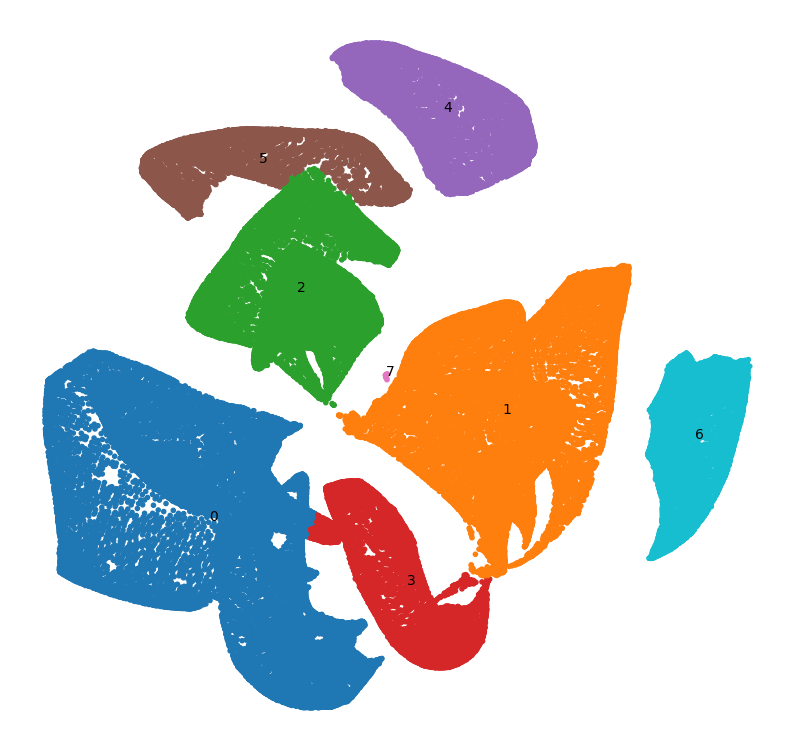

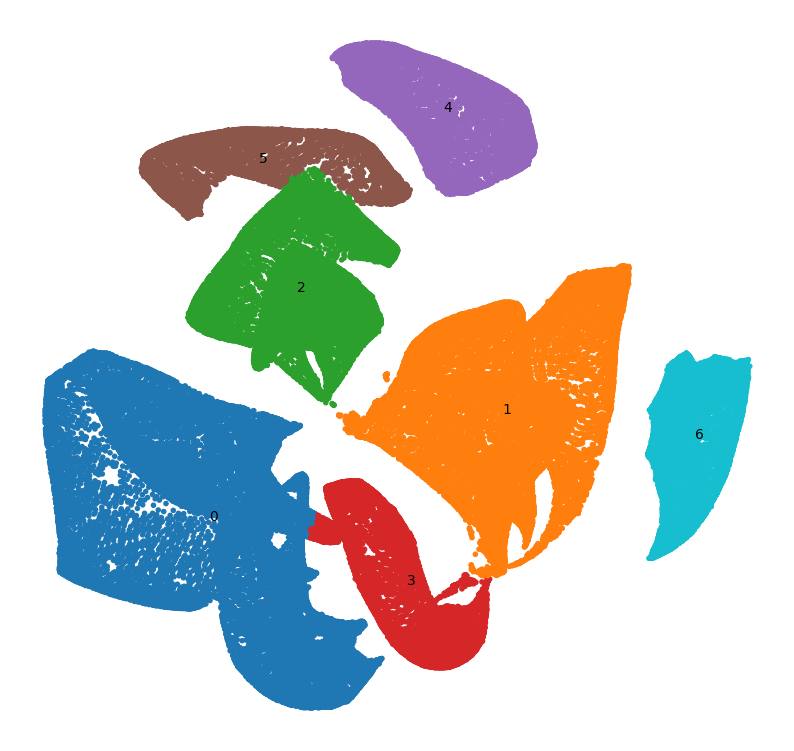

In [179]:
cluster_params = {
    'reducer_type': 'umap', 
    'n_neighbors': 15, 
    'metric': 'manhattan', # or 'euclidean',
    'min_dist': 0.0,
    'clusterer_type': 'leiden', 
    'dim_clust': 2, 
    'k_cluster': 15, 
    'resolution_parameter': 0.02,
}

cluster_labels, cluster_dir, nb_clust, _ = mosna.get_clusterer(var_aggreg, nas_dir, **cluster_params)

fig, ax = mosna.plot_clusters(embed_viz, cluster_labels, nas_dir, cluster_params=cluster_params)

cluster_labels_2 = mosna.merge_clusters_until(cluster_labels, embed_viz)
fig, ax = mosna.plot_clusters(embed_viz, cluster_labels_2, nas_dir, cluster_params=cluster_params)

On the contrary, optimizing the resolution lead to better clustering.